In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Generate Data
np.random.seed(364)
J = 3
n = 100
m = 10 
lam = 1
A = np.random.normal(loc = 0, scale = 1/m, size = (J, m, n))
x0 = np.random.normal(loc = 0, scale = 1/n, size = (J, n))
b = np.sum([A[j] @ x0[j] for j in range(J)], axis = 0)

In [15]:
# Define helper functions
def obj(b, A, x):
    return np.linalg.norm(b - np.sum([A[j] @ x[j] for j in range(A.shape[0])]), 1)

def subgrad_obj(b, A, x):
    g = np.ndarray(x.shape)
    for j in range(A.shape[0]):
        g[j] =  - np.sign(b - np.sum([A[i] @ x[i] for i in range(A.shape[0])])) @ A[j]
    return np.array(g)

def f_c1(A, x):
    return np.array([-A[j]@x[j] for j in range(A.shape[0])])

def subgrad_c1(A, x):
    g = np.ndarray(x.shape)
    f = f_c1(A, x)
    for j in range(A.shape[0]):
        if np.any(f[j] > 0):
            g[j] = A[j].T @ np.ones(A.shape[1])
        else:
            g[j] = np.zeros_like(x[j])
    return g

def f_c2(x, lam):
    return np.array([np.linalg.norm(x[j]-lam,2) for j in range(x.shape[0])])

def subgrad_c2(x, lam):
    g = np.ndarray(x.shape)
    f = f_c2(x, lam)
    for j in range(x.shape[0]):
        if f[j] > 0:
            g[j] = x[j].T
        else:
            g[j] = np.zeros_like(x[j])
    return g


# Part A: Constrained Subgradient Method

In [16]:
# constant step size
steps = 50
x = np.ndarray((steps+1, J, n))
max_violation = np.ndarray((steps))
objective = np.ndarray((steps))
x[0, :, :] = x0
alpha = 0.05
# Define the step size

for i in range(steps):
    # get the constraint violations
    f1 = f_c1(A, x[i, :, :])
    f2 = f_c2(x[i, :, :], lam)
    
    # track metrics
    max_violation[i] = np.max([np.max(f1), np.max(f2)])
    objective[i] = obj(b, A, x[i, :, :])

    # calculate subgradient
    if max_violation[i] >= 0:
        g = subgrad_obj(b, A, x[i, :, :])
    elif np.any(f1 > 0):
        g = subgrad_c1(A, x[i, :, :])
    elif np.any(f2 > 0):
        g = subgrad_c2(x[i, :, :], lam)

    # update x
    for j in range(J):
        x[i+1, j, :] = x[i, j, :] - alpha * g[j,:]

obj_a = objective.copy()
mvio_a = max_violation.copy()


In [17]:
# constant step length
gamma = 0.1
# Define the step size

for i in range(steps):
    # get the constraint violations
    f1 = f_c1(A, x[i, :, :])
    f2 = f_c2(x[i, :, :], lam)
    
    # track metrics
    max_violation[i] = np.max([np.max(f1), np.max(f2)])
    objective[i] = obj(b, A, x[i, :, :])

    # calculate subgradient
    if max_violation[i] >= 0:
        g = subgrad_obj(b, A, x[i, :, :])
    elif np.any(f1 > 0):
        g = subgrad_c1(A, x[i, :, :])
    elif np.any(f2 > 0):
        g = subgrad_c2(x[i, :, :], lam)

    # update x
    for j in range(J):
        a = gamma / np.linalg.norm(g,2)
        x[i+1, j, :] = x[i, j, :] - a * g[j,:]

obj_b = objective.copy()
mvio_b = max_violation.copy()

In [18]:
# 1/k step

for i in range(steps):
    # get the constraint violations
    f1 = f_c1(A, x[i, :, :])
    f2 = f_c2(x[i, :, :], lam)
    
    # track metrics
    max_violation[i] = np.max([np.max(f1), np.max(f2)])
    objective[i] = obj(b, A, x[i, :, :])

    # calculate subgradient
    if max_violation[i] >= 0:
        g = subgrad_obj(b, A, x[i, :, :])
    elif np.any(f1 > 0):
        g = subgrad_c1(A, x[i, :, :])
    elif np.any(f2 > 0):
        g = subgrad_c2(x[i, :, :], lam)

    # update x
    for j in range(J):
        x[i+1, j, :] = x[i, j, :] - g[j,:] / (i+1)

obj_c = objective.copy()
mvio_c = max_violation.copy()

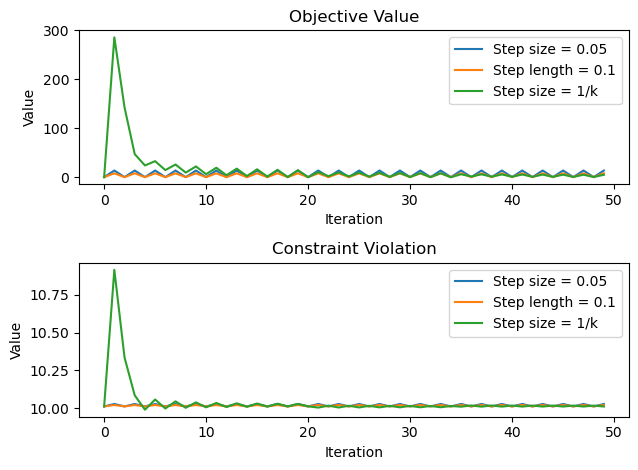

In [19]:
fig, ax = plt.subplots(2,1)
ax[0].plot(obj_a, label = "Step size = {}".format(alpha))
ax[0].plot(obj_b, label = "Step length = {}".format(gamma))
ax[0].plot(obj_c, label = "Step size = 1/k")
ax[0].set(title = 'Objective Value',
          ylabel = 'Value',
          xlabel = 'Iteration')
ax[0].legend()

ax[1].plot(mvio_a, label = "Step size = {}".format(alpha))
ax[1].plot(mvio_b, label = "Step length = {}".format(gamma))
ax[1].plot(mvio_c, label = "Step size = 1/k")
ax[1].set(title = 'Constraint Violation',
          ylabel = 'Value',
          xlabel = 'Iteration')
ax[1].legend()
fig.tight_layout()

# Part B: Primal-dual Subgradient Method

In [20]:
rho = 0.1


In [27]:
x = np.ndarray((steps+1, J, n))
l = np.ndarray((steps+1, J*2))          
max_violation = np.ndarray((steps))
objective = np.ndarray((steps))
x[0, :, :] = x0
l[0, :] = np.zeros(J*2)
alpha = 0.005

for i in range(steps):
    # get the constraint violations
    f1 = f_c1(A, x[i, :, :])
    f2 = f_c2(x[i, :, :], lam)
    fi = np.concatenate([np.linalg.norm(f1,2, axis = 1), f2])
    fi = np.where(fi <= 0, 0, fi)
    
    # track metrics
    max_violation[i] = np.max([np.max(f1), np.max(f2)])
    objective[i] = obj(b, A, x[i, :, :])

    # calculate all subgradients 
    g0 = subgrad_obj(b, A, x[i, :, :])
    g1 = subgrad_c1(A, x[i, :, :])
    g2 = subgrad_c2(x[i, :, :], lam)

    # primal update  
    primaldual = l[i, :] + rho * fi
    x[i+1, :, :] = x[i, :, :] - alpha * (g0 + primaldual.T @ nip.concatenate([g1, g2]))
    
    # dual update
    l[i+1, :] = l[i, :] + alpha * fi

objpd_a = objective.copy()
mvio_pd_a = max_violation.copy()

[Text(0.5, 1.0, 'Constraint Violation'),
 Text(0, 0.5, 'Value'),
 Text(0.5, 0, 'Iteration')]

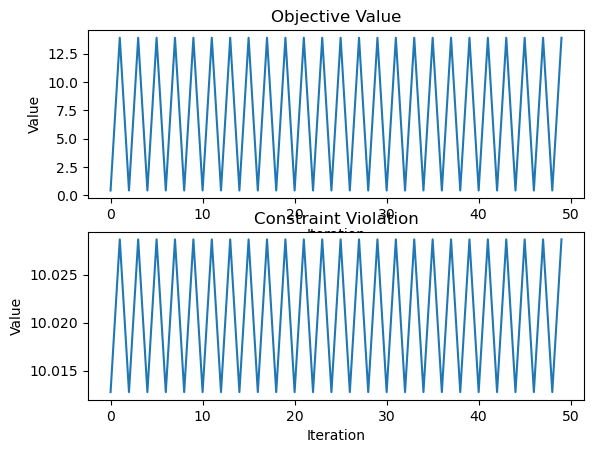

In [28]:
fig, ax = plt.subplots(2,1)
ax[0].plot(obj_a, label = "Step size = {}".format(alpha))
ax[0].set(title = 'Objective Value',
          ylabel = 'Value',
          xlabel = 'Iteration')
ax[1].plot(mvio_a, label = "Step size = {}".format(alpha))
ax[1].set(title = 'Constraint Violation',
          ylabel = 'Value',
          xlabel = 'Iteration')
